In [1]:
import os 
import random
import shutil
import math

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

from PIL import Image

import numpy as np
import pickle
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import utils

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

BATCH_SIZE=4
MAX_SEQUENCE_LENGTH=150
MANUAL_SEED = 1
HIDDEN_SIZE = 256
INPUT_SIZE=14

utils.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
utils.INPUT_SIZE = INPUT_SIZE


In [10]:


transform = transforms.Compose(
    [transforms.Resize((150,150)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder('../dataset/augmented/full_scanpath_dataset/', transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)



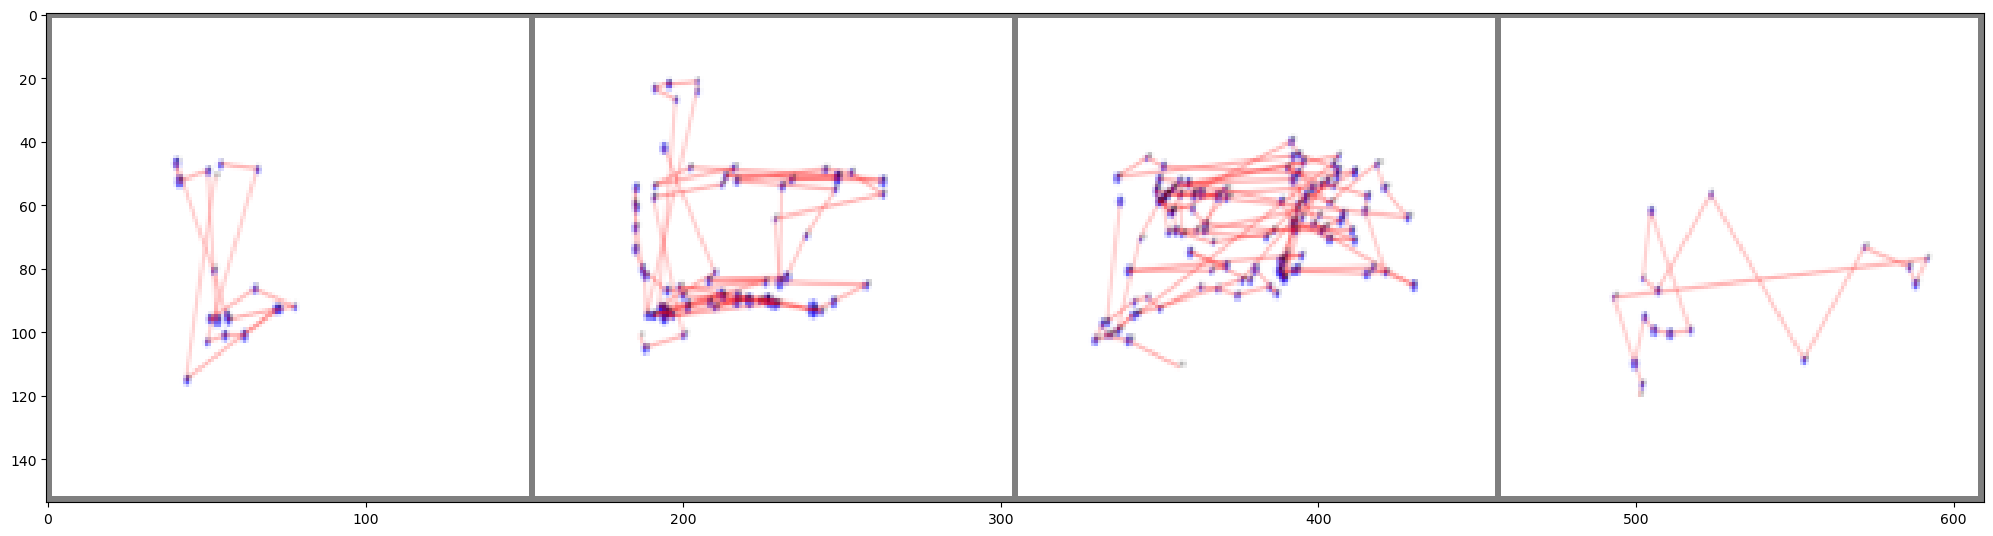

illterate-illterate-literate-illterate


In [19]:
classes = ('illterate', 'literate')
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('-'.join('%5s' % classes[labels[j]] for j in range(4)))

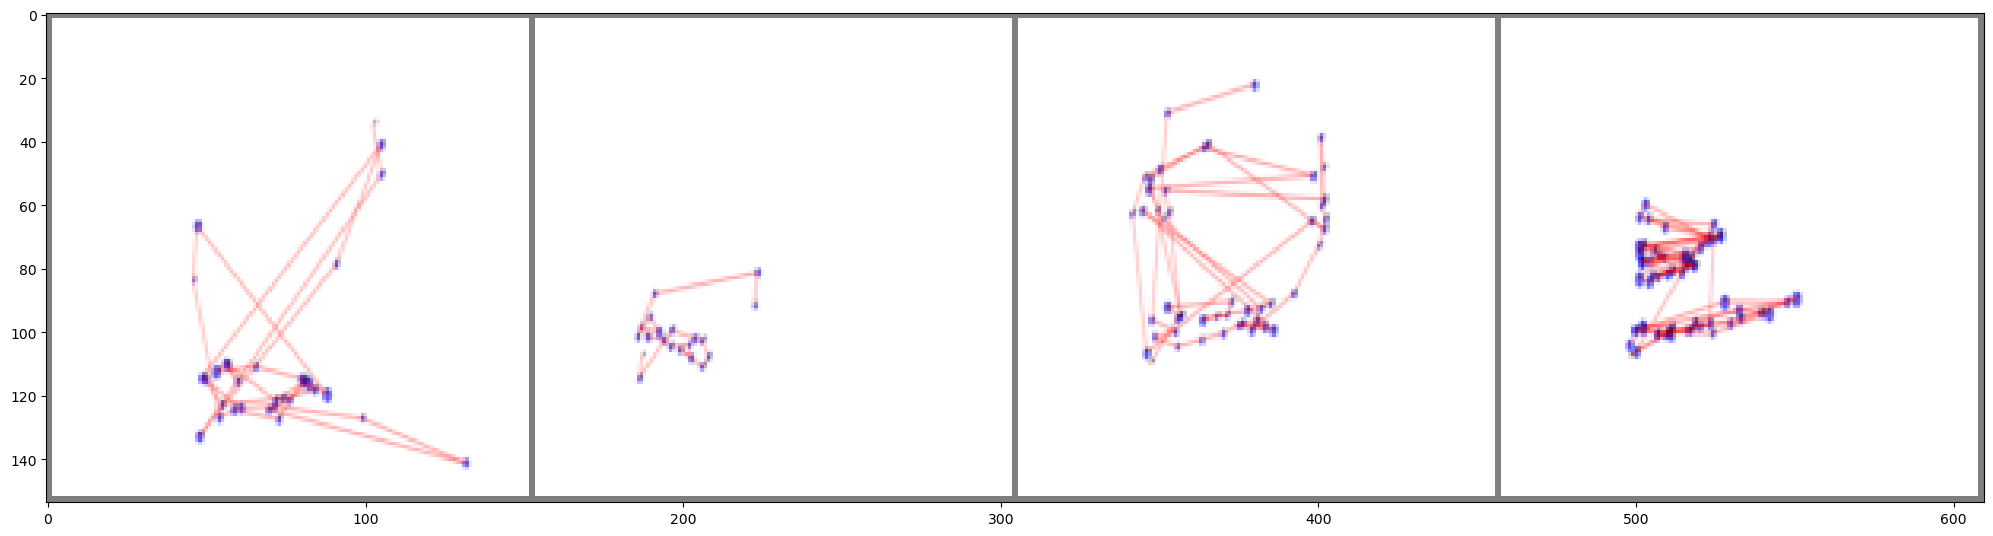

illterate-literate-literate-literate


In [20]:
classes = ('illterate', 'literate')
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('-'.join('%5s' % classes[labels[j]] for j in range(4)))

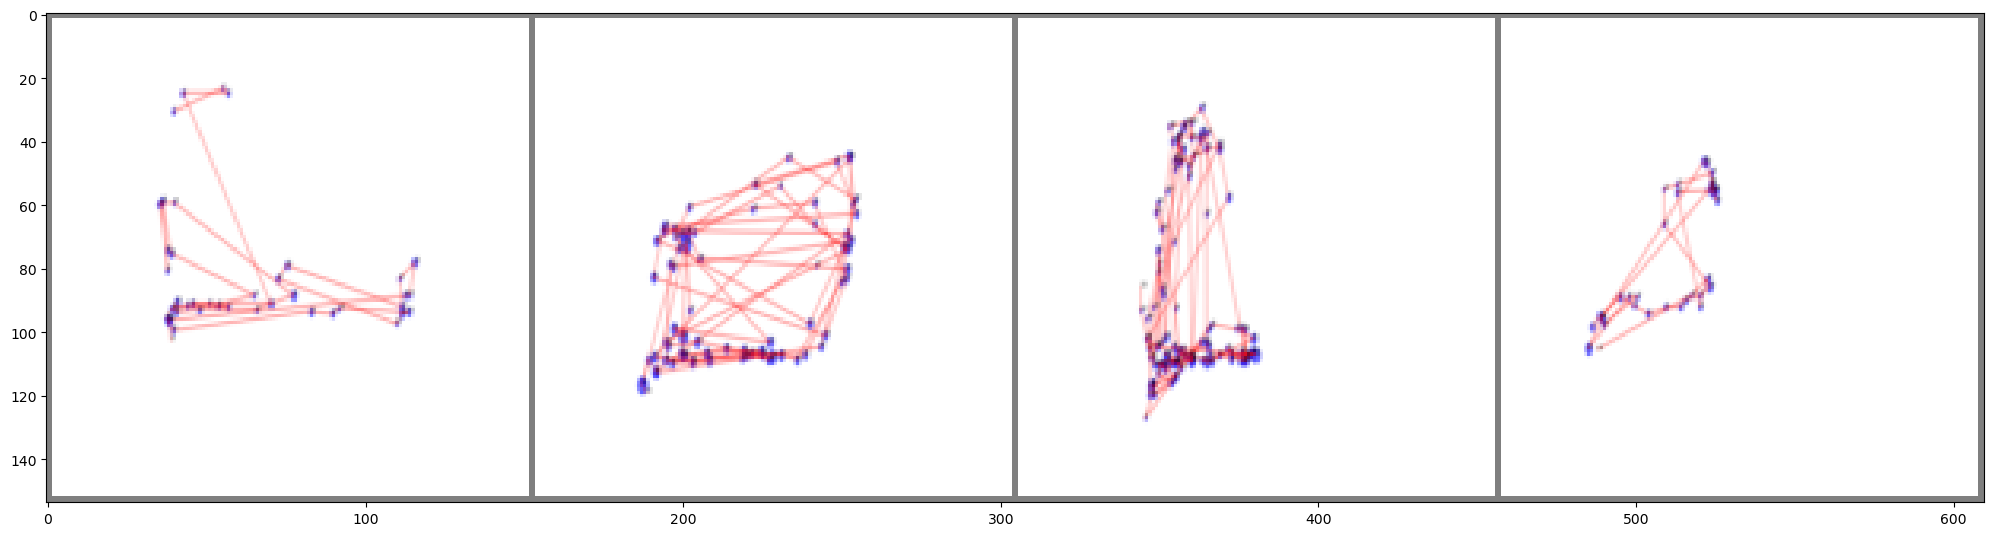

literate-illterate-illterate-literate


In [21]:
classes = ('illterate', 'literate')
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('-'.join('%5s' % classes[labels[j]] for j in range(4)))

Relevant cues are fixations, saccades, and the temporal development thereof. Model architecture needs to capture this. Thus we need a large receptive
field, but a hierarchy of parts is likely not as important as in vision applications.
We use one image channel because colour has no meaning.
We use images instead of a matrix of x,y gaze coordinates because we want the connections that come with a
scatter plot, as this encodes saccadic magnitude information, however coarsely.

In [22]:
class VTNet(nn.Module):
    def __init__(self,
                 input_size=2,
                 rnn_hidden_size=256,
                 output_size=2,
                 batch_size=4,
                 rnn_type='gru',
                 rnn_num_layers=1,
                 n_channels_1=6,
                 kernel_size_1=5,
                 n_channels_2=16,
                 kernel_size_2=5,
                 img_n_vert=150,
                 img_n_hor=150):
        """

        Args:
            input_size (int):
            hidden_size (int):
            output_size (int):
            batch_size (int):
            rnn_type (int):
            num_layers (int):
        """
        super(VTNet, self).__init__()

        self.n_channels_2 = n_channels_2


        # CNN portion
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_channels_1, kernel_size=kernel_size_1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_channels_1, out_channels=n_channels_2, kernel_size=kernel_size_2, stride=1)
        # output size calculations
        self.conv1_out_vert = img_n_vert - kernel_size_1 + 1
        self.conv1_out_hor = img_n_hor - kernel_size_1 + 1
        self.mp1_out_vert = int(np.floor((self.conv1_out_vert - 2)/2) + 1)
        self.mp1_out_hor = int(np.floor((self.conv1_out_hor - 2) / 2) + 1)
        self.conv2_out_vert = self.mp1_out_vert - kernel_size_2 + 1
        self.conv2_out_hor = self.mp1_out_hor - kernel_size_2 + 1
        self.mp2_out_vert = int(np.floor((self.conv2_out_vert - 2)/2) + 1)
        self.mp2_out_hor = int(np.floor((self.conv2_out_hor - 2) / 2) + 1)
        self.fc1 = nn.Linear(n_channels_2 * self.mp2_out_hor * self.mp2_out_vert, 50)
        self.fc2 = nn.Linear(rnn_hidden_size + 50, 20)
        self.fc3 = nn.Linear(20, output_size)

        # RNN portion
        self.rnn_type = rnn_type
        self.input_size = input_size
        self.rnn_hidden_size = rnn_hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.rnn_num_layers = rnn_num_layers



        if rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=rnn_hidden_size,
                               num_layers=rnn_num_layers)
        else:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers)

        self.out = nn.Linear(rnn_hidden_size, output_size)

    def forward(self, scan_path, time_series, hidden):
        """
            Args:
                scan_path (torch.Tensor): must be 349x231 for now
                time_series (torch.Tensor):
            Returns:
                x (float): logit for confusion prediction - requires cross entropy loss
        """
        x1 = self.pool(F.relu(self.conv1(scan_path)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = x1.view(-1, self.n_channels_2 * self.mp2_out_hor * self.mp2_out_vert)
        x1 = F.relu(self.fc1(x1))

        # change input shape to (max_seq_size, batch_size, input_features):
        x2 = time_series.permute(1, 0, 2)
        x2, hidden = self.rnn(x2, hidden)
        x2 = x2[-1, :, :]  # take only the last output

        x = torch.cat((x1, x2), 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def init_hidden(self, batch_size):
        """ Initializes the hidden state with zero tensors.
        """
        if self.rnn_type == 'lstm':
            return (autograd.Variable(torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size)).double().to(device),
                    autograd.Variable(torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size)).double().to(device))
        else:
            return autograd.Variable(torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size)).double().to(device)

    
def st_pickle_loader(input_file_path, max_length=150):
    """ Processes a raw data item into a scan path image and a time series
        for input into a STNet. Takes only gaze information into consideration.

        Args:
            input_file_name (string): the name of the data item to be loaded
            max_length (int): max number of samples to use for a given item.
                If -1, use all samples
        Returns:
            item (numpy.ndarray): the fully processed data item for RNN input
            item_sp (PIL Image): 

    """
    transform = transforms.Compose([transforms.Resize((150,150)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))])
    
    file = open(input_file_path, 'rb')
    item = pickle.load(file)
    item = item.values
    item[:,0] = (item[:,0] + item[:,7])/2 #column 0 is now ave Gx
    item[:,1] = (item[:,1] + item[:,8])/2 #column 1 is now ave Gy
    item = item[item[:,0] > 0]
    item = abs(item)
    item[item == 1.0] = -1.0
    
    #determine if item was done in horizontal or vertical layout:
    item_name = input_file_path.split('/')[-1]
    orientation = item_name.split('-')[0][-1]
    # remove any glances to 'I'm Confused' button
    if orientation == 'H':
        item = item[(item[:,0] < 775.0) | (item[:,0] > 880.0) | (item[:,1] < 334.0) | (item[:,1] > 419.0)]
    elif orientation == 'V':
        item = item[(item[:,0] < 928.0) | (item[:,0] > 1034.0) | (item[:,1] < 226.0) | (item[:,1] > 312.0)]
    else:
        print("ERROR: didn't extract orientation from file name")
        return
    
    item = item[:,[0,1]] # drop all but Gx, Gy
    
    if max_length != -1:
        item = item[-max_length:,:]
        if len(item) < max_length:
            num_zeros_to_pad = (max_length)-len(item)
            item = np.append(np.zeros((num_zeros_to_pad, 2)), item, axis=0)
    file.close()
    
    path_to_sp = '../dataset/augmented/full_scanpath_dataset/' + '/'.join(input_file_path.split('/')[4:])[:-4] + ".png"
    im = Image.open(path_to_sp)
    item_sp = transform(im)[0:3,:,:]
    #print("item_sp shape: ", item_sp.shape)
    #item_sp = np.array(im)
    
    return item, item_sp   

In [24]:
net = VTNet(rnn_type='rnn').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
print(net)

VTNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=50, bias=True)
  (fc2): Linear(in_features=306, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (rnn): RNN(2, 256)
  (out): Linear(in_features=256, out_features=2, bias=True)
)


In [25]:
# base model - was 1422278
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
num_params

1000678

In [26]:
def cross_validate( model_type, 
                    folds,
                    epochs,
                    criterion_type,
                    optimizer_type,
                    confused_path,
                    not_confused_path,
                    print_every,
                    plot_every,
                    hidden_size,
                    num_layers,
                    down_sample_training=True,
                    learning_rate=0.0001,
                    path_to_data_split='../dataset/grouped_10_fold_split_list.pickle',
                    verbose=False):
    """
        Perform Cross Validation of the model using k-folds.
        
        Args:
            model_type (string): the type of RNN to use. Must be 'lstm', 'gru', or 'rnn'
            epochs (int): the max number of epochs to train the model for each fold
            criterion_type (string): the name loss function to use for training. Currently must be 'NLLLoss'
            optimizer_type (string): the name of learning algorithm to use for training. ex 'Adam'
            confused_path (string): the path to the folder containing the confused data samples
            not_confused_path (string): the path to the folder containing the not_confused data samples
            print_every (int): the number of batches to train for before printing relevant stats
            plot_every (int): the number of batches to train for before recording relevant stats, which
                will be plotted after each fold
            hidden_size (int): the number of hidden units for each layer of the RNN
            num_layers (int): the number of hidden_unit sized layers of the RNN
            down_sample_training (boolean): if True training set will be balanced by down sampling not_confused
            learning_rate (float): the first learning rate to be used by the optimizer
            path_to_data_split (string): relative path to the file containing the item names for each CV fold
            verbose (boolean): if True, function will print additional stats

        Returns: (list,list,list,list,list)
            cv_val_sens (list): list containing the validation sensitivity for each fold
            cv_val_spec (list): list containing the validation specificity for each fold
            cv_test_combined (list): list containing the combined test accuracy for each fold
    """

    
    confused_file_names = os.listdir(confused_path)
    not_confused_file_names = os.listdir(not_confused_path)
    if '.DS_Store' in confused_file_names:
        confused_file_names.remove('.DS_Store')
    if '.DS_Store' in not_confused_file_names:
        not_confused_file_names.remove('.DS_Store')
    
    #ensure same items appear in folds, for reproducibility:
    infile = open(path_to_data_split,'rb') 
    split = pickle.load(infile)
    infile.close()
    
    train_confused_splits = split[0]
    test_confused_splits = split[1]
    train_not_confused_splits = split[2]
    test_not_confused_splits = split[3]
    
    
    cv_test_sens = []
    cv_test_spec = []
    cv_test_combined = []
    cv_auc = []
    
    for k in range(folds):
        print("\nFold ", k+1)
        
        # Get data item file names for this fold and downsample not_confused to balance training set

        train_confused, \
        train_not_confused, \
        val_confused, \
        val_not_confused = \
        utils.get_train_val_split(train_confused_splits[k], train_not_confused_splits[k], percent_val_set=0.2)

        if down_sample_training:
            train_not_confused = random.sample(train_not_confused, k=(len(train_confused)))
        
        test_confused = test_confused_splits[k]
        test_not_confused = test_not_confused_splits[k]

        if verbose:
            print("confused items in training set: ", len(train_confused))
            print("not_confused items in training set: ", len(train_not_confused))
            print("confused items in validation set: ", len(val_confused))
            print("not_confused items in validation set: ", len(val_not_confused))
        
        if verbose:
            print("\nTest confused items:\n")
            print(test_confused)

            
            
        local_train_confused_path = '../dataset/augmented/train2/confused/'
        local_val_confused_path = '../dataset/augmented/val2/confused/'
        local_test_confused_path = '../dataset/augmented/test2/confused/'
        local_train_not_confused_path = '../dataset/augmented/train2/not_confused/'
        local_val_not_confused_path = '../dataset/augmented/val2/not_confused/'
        local_test_not_confused_path = '../dataset/augmented/test2/not_confused/'

        # Remove any old directories
        if os.path.exists(local_train_confused_path):
            shutil.rmtree(local_train_confused_path)
        if os.path.exists(local_val_confused_path):
            shutil.rmtree(local_val_confused_path)
        if os.path.exists(local_test_confused_path):
            shutil.rmtree(local_test_confused_path)
            
        if os.path.exists(local_train_not_confused_path):
            shutil.rmtree(local_train_not_confused_path)
        if os.path.exists(local_val_not_confused_path):
            shutil.rmtree(local_val_not_confused_path)
        if os.path.exists(local_test_not_confused_path):
            shutil.rmtree(local_test_not_confused_path)
            
        # Make new temp directories
        os.makedirs(local_train_confused_path)
        for i in train_confused:
            shutil.copy(src=confused_path+i,dst=local_train_confused_path+i)
        
        os.makedirs(local_val_confused_path)
        for i in val_confused:
            shutil.copy(src=confused_path+i,dst=local_val_confused_path+i)
        
        os.makedirs(local_test_confused_path)
        for i in test_confused:
            shutil.copy(src=confused_path+i,dst=local_test_confused_path+i)
        
        os.makedirs(local_train_not_confused_path)
        for i in train_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_train_not_confused_path+i)
            
        os.makedirs(local_val_not_confused_path)
        for i in val_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_val_not_confused_path+i)
        
        os.makedirs(local_test_not_confused_path)
        for i in test_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_test_not_confused_path+i)

        # Prepare training and validation data
        trainset = datasets.DatasetFolder('../dataset/augmented/train2/', 
                                               loader=st_pickle_loader, 
                                               extensions='.pkl')

        valset = datasets.DatasetFolder('../dataset/augmented/val2/', 
                                                 loader=st_pickle_loader, 
                                                 extensions='.pkl')
        
        testset = datasets.DatasetFolder('../dataset/augmented/test2/', 
                                                 loader=st_pickle_loader, 
                                                 extensions='.pkl')
    
        
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)


        testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)


        valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=True)

        print("Training data: ", trainset)
        print("Validation data: ", valset)
        print("Test data: ", testset)
        
        torch.manual_seed(MANUAL_SEED)
        if model_type == 'gru':
            model = VTNet(rnn_type='gru', rnn_num_layers=num_layers, rnn_hidden_size=hidden_size).double().to(device)
        elif model_type == 'lstm':
            model = VTNet(rnn_type='lstm', rnn_num_layers=num_layers, rnn_hidden_size=hidden_size).double().to(device)
        else:
            model = VTNet(rnn_type='rnn', rnn_num_layers=num_layers, rnn_hidden_size=hidden_size).double().to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        #save fresh model to clear any old ones out
        torch.save(model.state_dict(), './best_STNet_fold_'+str(k) +'.pt')
        best_val_combined = 0.0
        #Train model 
        for epoch in range(epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            epoch_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                item, item_sp = inputs[0].double(), inputs[1].double()
                item, item_sp, labels = item.to(device), item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                hidden = model.init_hidden(BATCH_SIZE)
                # forward + backward + optimize
                outputs = model(scan_path=item_sp, time_series=item, hidden=hidden)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                epoch_loss += loss.item()
                if i % 10 == 0:
                    print('[%d, %5d] loss: %.5f' %
                          (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0
            print('epoch %d average training loss: %.5f' % (epoch + 1, epoch_loss/ len(trainloader)))

            #check validation set metrics
            running_val_loss = 0.0
            y_true = torch.zeros((len(valloader)*4))
            y_scores = torch.zeros((len(valloader)*4, 2))
            with torch.no_grad():

                for i, data in enumerate(valloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    item, item_sp = inputs[0].double(), inputs[1].double()
                    item, item_sp, labels = item.to(device), item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    hidden = model.init_hidden(BATCH_SIZE)
                    # forward + backward + optimize
                    outputs = model(scan_path=item_sp, time_series=item, hidden=hidden)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()
                    #keep track of predictions
                    num_items = outputs.shape[0]
                    y_true[i*num_items: i*num_items + num_items] = labels
                    y_scores[i*num_items: i*num_items + num_items, :] = outputs.squeeze()

                val_loss = running_val_loss/ len(valloader)
                print('epoch %d average val loss: %.5f' % (epoch + 1, val_loss))

                #check metrics:
                # no option to specify positive label, so flipping for confused=1
                y_true_flipped = np.array(y_true.numpy(), copy=True)
                y_true_flipped[y_true == 1] = 0
                y_true_flipped[y_true == 0] = 1
                #auc = roc_auc_score(y_true_flipped, y_scores.numpy()[:,0])
                # roc_curve expects y_scores to be probability values of the positive class
                fpr, tpr, thresholds = roc_curve(y_true, y_scores.numpy()[:,0], pos_label=0)

                sensitivity, specificity, \
                accuracy = utils.optimal_threshold_sensitivity_specificity(thresholds[1:],
                                                                           tpr[1:],
                                                                           fpr[1:],
                                                                           y_true,
                                                                           y_scores.numpy()[:,0])
                combined = (sensitivity + specificity ) / 2.0
                print("epoch %d validation sens. : %.5f, spec. : %.5f; combined: %.5f"
                      % (epoch + 1, sensitivity, specificity, combined))
                if combined > best_val_combined:
                    print("New best validation combined accuracy found. Saving model...")
                    best_val_combined = combined
                    torch.save(model.state_dict(), './best_base_STNet_fold_'+str(k) +'.pt')
            

        with torch.no_grad():
            model.load_state_dict(torch.load('./best_base_STNet_fold_'+str(k) +'.pt'))
            for i, data in enumerate(testloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                item, item_sp = inputs[0].double(), inputs[1].double()
                item, item_sp, labels = item.to(device), item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                hidden = model.init_hidden(BATCH_SIZE)
                # forward + backward + optimize
                outputs = model(scan_path=item_sp, time_series=item, hidden=hidden)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                #keep track of predictions
                num_items = outputs.shape[0]
                y_true[i*num_items: i*num_items + num_items] = labels
                y_scores[i*num_items: i*num_items + num_items, :] = outputs.squeeze()

            #y_pred = torch.argmax(y_scores, axis=1)
            
            #check metrics:
            # no option to specify positive label, so flipping for confused=1
            y_true_flipped = np.array(y_true.numpy(), copy=True)
            y_true_flipped[y_true == 1] = 0
            y_true_flipped[y_true == 0] = 1
            auc = roc_auc_score(y_true_flipped, y_scores.numpy()[:,0])
            # roc_curve expects y_scores to be probability values of the positive class
            fpr, tpr, thresholds = roc_curve(y_true, y_scores.numpy()[:,0], pos_label=0)
            
            sensitivity, specificity, \
            accuracy = utils.optimal_threshold_sensitivity_specificity(thresholds[1:],
                                                                       tpr[1:],
                                                                       fpr[1:],
                                                                       y_true,
                                                                       y_scores.numpy()[:,0])
            combined = (sensitivity + specificity ) / 2.0

            
            
            
            
            print("Test set sens. : %.5f, spec. : %.5f, combined: %.5f, auc: %.5f" % (sensitivity, specificity, combined, auc))
            cv_test_sens.append(sensitivity)
            cv_test_spec.append(specificity)
            cv_test_combined.append(combined)
            cv_auc.append(auc)
            
    print("\n Average 10-fold CV test sensitivity: %.5f, specificity: %.5f, combined: %.5f, AUC: %.5f" % 
          ((sum(cv_test_sens)/len(cv_test_sens)), 
           (sum(cv_test_spec)/len(cv_test_spec)), 
           (sum(cv_test_combined)/len(cv_test_combined)),
           (sum(cv_auc)/len(cv_auc))))
    return cv_test_sens, cv_test_spec, cv_test_combined, cv_auc        


In [27]:
# compute for 10 different seeds
sens = []
spec = []
comb = []
auc = []


for i in range(10):
# baseline 10-fold CV with GRU
    np.random.seed(MANUAL_SEED+i)
    random.seed(MANUAL_SEED+i)
    torch.manual_seed(MANUAL_SEED+i)

    sens_list, spec_list, comb_list, auc_list = cross_validate(model_type='gru',
                                               folds=10,
                                               epochs=30,
                                               criterion_type='NLLLoss',
                                               optimizer_type='Adam',
                                               confused_path='../dataset/augmented/confused_highly_valid_new/',
                                               not_confused_path='../dataset/augmented/not_confused_highly_valid_new/',
                                               print_every=1,
                                               plot_every=1,
                                               hidden_size=HIDDEN_SIZE,
                                               down_sample_training=True,
                                               num_layers=1,
                                               learning_rate=0.0001,
                                               verbose=True)
    # add mean of each measure for 10-fold CV to list
    sens.append(np.mean(sens_list))
    spec.append(np.mean(spec_list))
    comb.append(np.mean(comb_list))
    auc.append(np.mean(auc_list))
    
print("sensitivities: ", sens)
print("specificities: ", spec)
print("combined: ", comb)
print("auc: ", auc)

print("average sensitivity: ", np.mean(sens))
print("average specificity: ", np.mean(spec))
print("average combined: ", np.mean(comb))
print("average auc: ", np.mean(auc))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../dataset/augmented/confused_highly_valid_new/'

In [1]:
sensitivities = [0.807931575412489, 0.7908261494450481, 0.7903097515056213, 0.7765463411223736, 0.783870471483738, 0.80606186342513, 0.7720922400329472, 0.8088779163056385, 0.7567712456504696, 0.8006382948160169]
specificities = [0.8583375583941093, 0.8337928866719059, 0.8360599469030561, 0.8253520601735648, 0.8439646792511347, 0.8431171553398926, 0.8326065813468263, 0.8437149260778579, 0.861630124023854, 0.8398190109593496]

for s in sensitivities:
    print(s)
    

0.807931575412489
0.7908261494450481
0.7903097515056213
0.7765463411223736
0.783870471483738
0.80606186342513
0.7720922400329472
0.8088779163056385
0.7567712456504696
0.8006382948160169


In [2]:
for s in specificities:
    print(s)

0.8583375583941093
0.8337928866719059
0.8360599469030561
0.8253520601735648
0.8439646792511347
0.8431171553398926
0.8326065813468263
0.8437149260778579
0.861630124023854
0.8398190109593496
